# Proof of concept - online rhat

In [1]:
import blackjax
import jax
import chex
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
from blackjax.diagnostics import potential_scale_reduction
import matplotlib.pyplot as plt
from typing import NamedTuple
from jax.tree_util import tree_map, tree_structure

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [2]:
class WelfordState(NamedTuple):
    K: chex.Array
    Ex: chex.Array
    Ex2: chex.Array
    n: chex.Array


def welford_init(K) -> WelfordState:
  """Initialize new welford algorithm state.
  
  Args:
    K: estimated mean value of data. Same shape as data.
  """
  return WelfordState(K=K*1., Ex=K*0., Ex2=K*0., n=K*0)

def welford_add(x: chex.Array, state: WelfordState) -> WelfordState:
  return WelfordState(K=state.K, Ex=state.Ex + x - state.K, Ex2=state.Ex2 + (x - state.K)**2, n=state.n + 1)

def welford_mean(state: WelfordState):
  return state.K + state.Ex / state.n

def welford_var(state: WelfordState):
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)

In [3]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array
    post_id: chex.Array

In [4]:
class ExtendedState(NamedTuple):
    state: object
    rng_key: chex.Array
    pred_ws: WelfordState
    param_ws: WelfordState

In [5]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

def logprob_fn(theta: Theta):
  sigsq = sigsq_t.forward(theta.sigsq)
  sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
  lprior = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(theta.sigsq)
  lhood = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y).sum()
  return lprior + lhood

In [7]:
num_samples = 500
warmup_iter = 500
num_chains = 10
seed = 123
warmup_key, sampling_key, init_key, subs_key = jax.random.split(jax.random.PRNGKey(seed), 4)

# random initialization in the constrained parameter space
def make_initial_pos(key, pid):
  k1, k2 = jax.random.split(key)
  theta = Theta(
    beta=jax.random.normal(key=k1, shape=(p,)),
    sigsq=jax.random.normal(key=k2),
    post_id=1.0*pid)
  return theta

In [8]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logprob_fn, num_steps=warmup_iter, progress_bar=True)
final_warmup_state, kernel, info = warmup.run(warmup_key, make_initial_pos(init_key, 0))

Running window adaptation



CPU times: user 4.62 s, sys: 33.1 ms, total: 4.65 s
Wall time: 4.61 s


In [9]:
# sample initial positions from second half of warmup trajectory
idxs = jax.random.choice(subs_key, a=jnp.arange(warmup_iter//2, warmup_iter), shape=(num_chains,))
initial_positions = Theta(
    beta = info[0].position.beta[idxs,],
    sigsq = info[0].position.sigsq[idxs],
    post_id = 1.0*jnp.arange(num_chains)
)
initial_states = jax.vmap(lambda p: blackjax.nuts.init(p, logprob_fn))(initial_positions)

In [10]:
# sense check logprob_fn
[logprob_fn(final_warmup_state.position), jax.vmap(logprob_fn)(initial_positions)]

[Array(-196.40106, dtype=float32),
 Array([-192.4809 , -190.7263 , -194.34314, -193.96323, -191.08167,
        -193.45099, -190.05582, -191.68242, -195.66983, -194.12477],      dtype=float32)]

Seems pretty safe to sample from second half of warmup trace:

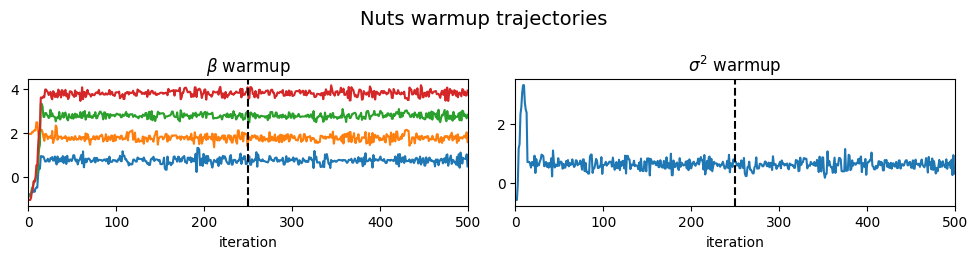

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,2.6))
bax, sax = axes
bax.plot(info[0].position.beta)
bax.set_title(r'$\beta$ warmup')
sax.plot(info[0].position.sigsq)
sax.set_title(r'$\sigma^2$ warmup')
for ax in axes:
    ax.set_xlabel('iteration')
    ax.axvline(warmup_iter//2, color='k', linestyle='--')
    ax.set_xlim(0, info[0].position.beta.shape[0])
fig.suptitle('Nuts warmup trajectories', fontsize=14)
fig.tight_layout()

Named tuple for holding MCMC results, split into 2 half-chains

In [12]:
class MCMCResults(NamedTuple):
    state1h: ExtendedState
    state2h: ExtendedState
    trace1h: blackjax.mcmc.hmc.HMCState
    trace2h: blackjax.mcmc.hmc.HMCState

In [13]:
# single chain inference loop we will run in parallel using vmap
def inference_loop(rng_key, kernel, initial_state, num_samples) -> MCMCResults:
    def log_p(theta):
        e = X @ theta.beta - y
        return -0.5 * (
            jnp.log(2 * jnp.pi)
            + jnp.log(theta.sigsq)
            + jnp.dot(e, e)/theta.sigsq
        )
    def one_mcmc_step(extended_state, idx):
        i_key, carry_key = jax.random.split(extended_state.rng_key)
        chain_state, _ = kernel(i_key, extended_state.state)
        elpd_contrib = log_p(chain_state.position)
        carry_pred_ws = welford_add(elpd_contrib, extended_state.pred_ws)
        carry_param_ws = tree_map(welford_add, chain_state.position, extended_state.param_ws)
        carry_state = ExtendedState(chain_state, carry_key, carry_pred_ws, carry_param_ws)
        return carry_state, chain_state  # we'll eventually drop chain state and return None instead
    # first half of chain
    initial_state_1h = ExtendedState(
        initial_state,
        rng_key,
        pred_ws=welford_init(log_p(initial_state.position)),
        param_ws=tree_map(welford_init, initial_state.position))
    #carry_state_1h = jax.lax.fori_loop(0, num_samples//2, one_step, initial_state_1h)
    carry_state_1h, states_1h = jax.lax.scan(one_mcmc_step, initial_state_1h, jnp.arange(num_samples//2))
    # second half of chain
    initial_state_2h = ExtendedState(
        carry_state_1h.state,
        carry_state_1h.rng_key,
        pred_ws=welford_init(log_p(carry_state_1h.state.position)),
        param_ws=tree_map(welford_init, carry_state_1h.state.position))
    #carry_state_2h = jax.lax.fori_loop(0, num_samples//2, one_step, carry_state_1h)
    carry_state_2h, states_2h = jax.lax.scan(one_mcmc_step, carry_state_1h, jnp.arange(num_samples//2, num_samples))
    return MCMCResults(carry_state_1h, carry_state_2h, states_1h, states_2h)

In [14]:
# smoke test a single chain
res = inference_loop(sampling_key, kernel, final_warmup_state, num_samples)

In [15]:
%%time

sampling_keys = jax.random.split(sampling_key, num_chains)

res = jax.vmap(inference_loop, in_axes=(0, None, 0, None))(
    sampling_keys, kernel, initial_states, num_samples)

CPU times: user 14.7 s, sys: 42.6 ms, total: 14.7 s
Wall time: 14.7 s


In [16]:
def split_rhat(results: MCMCResults) -> float:
    # split chain means
    means = jnp.hstack([
        jax.vmap(welford_mean)(results.state1h.welford_state),
        jax.vmap(welford_mean)(results.state2h.welford_state)])
    # split chain sample variances
    vars = jnp.hstack([
        jax.vmap(welford_var)(results.state1h.welford_state),
        jax.vmap(welford_var)(results.state2h.welford_state)])
    W = jnp.mean(vars)
    # number of draws per split chain (ie half draws in an original chain)
    n = results[0].welford_state.n[0]
    # number of split chains
    m = len(means)
    B = n*jnp.var(means, ddof=1)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat